In [124]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import requests
import zipfile
from tqdm import tqdm

# # Get project files
# # Download the file
# url = "https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip"
# response = requests.get(url, stream=True)
# file_size = int(response.headers.get('content-length', 0))

# print("Downloading cats_and_dogs.zip...")
# with open("cats_and_dogs.zip", "wb") as file:
#     for data in tqdm(response.iter_content(chunk_size=1024), total=file_size//1024, unit='KB'):
#         file.write(data)

# # Extract the zip file
# print("Extracting files...")
# with zipfile.ZipFile("cats_and_dogs.zip", "r") as zip_ref:
#     zip_ref.extractall(".")

# print("Download and extraction complete!")

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')
# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 32
epochs = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [139]:
# 3
# Create an image generator with data augmentation for training
train_image_generator = ImageDataGenerator(
	rescale=1./255,
	horizontal_flip=True,
	fill_mode='nearest'
)

# For validation and test data, we only rescale
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Create the data generators
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
														 directory=train_dir,
														 target_size=(IMG_HEIGHT, IMG_WIDTH),
														 class_mode='binary'
														)

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
														   directory=validation_dir,
														   target_size=(IMG_HEIGHT, IMG_WIDTH),
														   class_mode='binary'
														  )

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
													   directory=test_dir,
													   target_size=(IMG_HEIGHT, IMG_WIDTH),
													   class_mode='binary',
													   shuffle=False
													  )


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


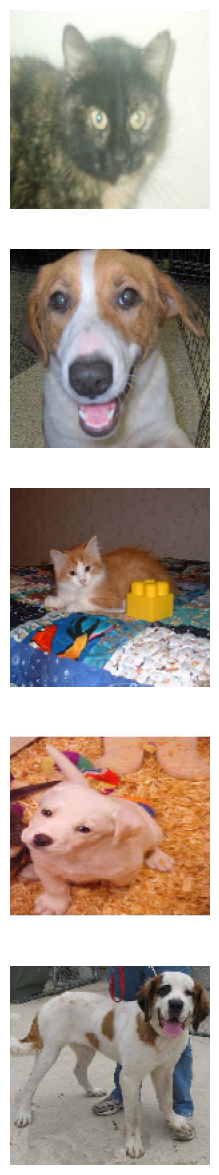

In [35]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [156]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,                 # Rescale pixel values
    rotation_range=20,              # Randomly rotate images
    width_shift_range =0.3,          # Randomly shift images horizontally
    height_shift_range=0.3,         # Randomly shift images vertically
    zoom_range=0.3,                 # Randomly zoom images
    horizontal_flip=True,           # Randomly flip images horizontally
    brightness_range=[0.8,1.2],    # Randomly adjust brightness
    fill_mode='nearest'             # Fill in newly created pixels
)


Found 2000 images belonging to 2 classes.


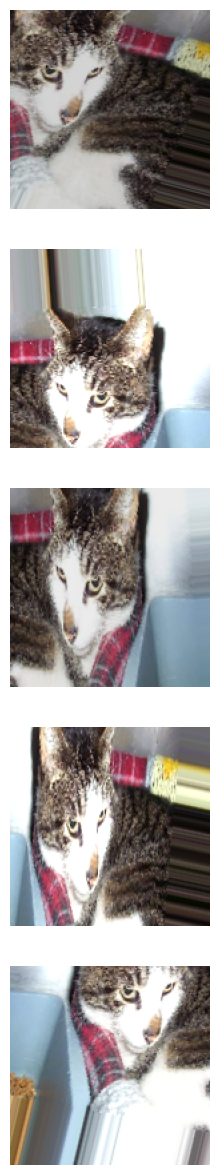

In [157]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    class_mode='binary',
                                                    )

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [170]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [171]:
# 8


epochs = 5
# Train the model
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/5
15/15 [==============================] - 24s 2s/step - loss: 0.8349 - accuracy: 0.4952 - val_loss: 0.7006 - val_accuracy: 0.4989
Epoch 2/5
15/15 [==============================] - 20s 1s/step - loss: 0.6916 - accuracy: 0.5080 - val_loss: 0.6695 - val_accuracy: 0.5279
Epoch 3/5
15/15 [==============================] - 23s 2s/step - loss: 0.6749 - accuracy: 0.5278 - val_loss: 0.6651 - val_accuracy: 0.5960
Epoch 4/5
15/15 [==============================] - 25s 2s/step - loss: 0.6710 - accuracy: 0.5609 - val_loss: 0.6544 - val_accuracy: 0.5993
Epoch 5/5
15/15 [==============================] - 25s 2s/step - loss: 0.6569 - accuracy: 0.5753 - val_loss: 0.6382 - val_accuracy: 0.6205


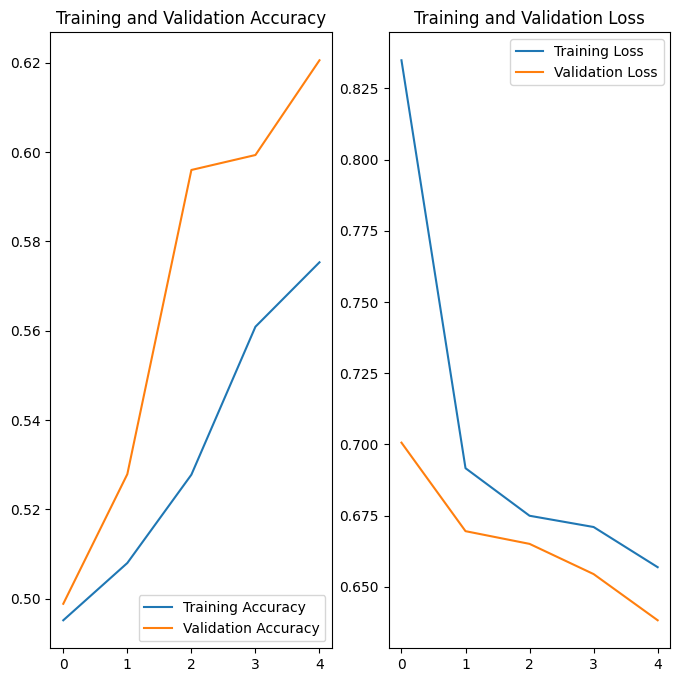

In [172]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [173]:
# 10


# Print the generator info to check how many batches are in the test generator
print(batch_size)
print("Number of batches:", len(test_data_gen))  # This is the number of batches

# Use model.predict with steps equal to the number of batches in test_data_gen
probabilities = model.predict(test_data_gen, steps=len(test_data_gen)).flatten()

# You may want to make sure the probabilities match the number of test images
total_test = 50  # Assuming you know there are 50 test images
probabilities = probabilities[:total_test]  # Limit to the actual number of test images

# Now you can use the probabilities as needed
print(probabilities)



128
Number of batches: 1
1/1 [==============================] - 0s 212ms/step
[0.45990896 0.43731785 0.47364947 0.5961057  0.49257767 0.47660005
 0.47649363 0.46333757 0.5363844  0.8209005  0.49822646 0.4517144
 0.44740522 0.3577072  0.44376305 0.5675026  0.4442894  0.47696334
 0.4488692  0.4688559  0.47499323 0.46027634 0.42685446 0.45354626
 0.45432654 0.47731254 0.97429216 0.45139942 0.451604   0.45049584
 0.5802887  0.48028564 0.5551825  0.9998472  0.51862    0.47993666
 0.9865638  0.5253038  0.42849052 0.47433248 0.47587758 0.45275718
 0.73325115 0.44355783 0.51212007 0.44344297 0.467276   0.48497579
 0.37871036 0.4861087 ]


In [175]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 66.0% of the images of cats and dogs.
You passed the challenge!
